# Yandex.Music Обнаружение каверов музыкальных треков

## Общее описание задачи

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

  * по желанию пользователя можем полностью исключить каверы из рекомендаций;
  * показать все каверы на любимый трек пользователя;
  * контролировать долю каверов в ленте пользователя.
  
## Цели

В этом хакатоне нам предлагается разработать решение, которое:
  * может классифицировать треки по признаку кавер-некавер;
  * связывать (группировать) каверы и исходный трек;
  * находит исходный трек в цепочке каверов.


## Описание данных

Разметка каверов

Файл **covers.json** содержит разметку каверов, сделанную редакторами сервиса:

   * `track_id` – уникальный идентификатор трека;

   * `original_track_id` – уникальный идентификатор исходного трека;

   * `track_remake_type` – метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER.

Метаинформация

Файл **meta.json** содержит следующую информацию:

   * `track_id` – уникальный идентификатор трека;

   * `dttm` – первая дата появления информации о треке;

   * `title` – название трека;

   * `language` – язык исполнения;

   * `isrc` – международный уникальный идентификатор трека;

   * `genres` – жанры;

   * `duration` – длительность трека.

Тексты песен

Файл **lyrics.json** содержит следующую информацию:

   * `track_id` – уникальный идентификатор трека;

   * `lyricId` – уникальный идентификатор текста;

   * `text` – текст трека.
   
## Предполагаемые стратегии решения задачи

  * Прямой подход
    * очистим, исправим ошибки и объединим данные
    * преобразуем тексты песен, названия и жанры в векторное представление
    * объединим с другими признаками и получим набор данных для обучения
    * подберём и настроим модель для предсказания метки кавер/не кавер

  * Попарное сравнение треков
    * очистим, исправим ошибки и объединим данные
    * преобразуем тексты песен в векторное представление
    * сделаем попарное сравнение дистанций между разными треками
    * объединим с другими признаками для этих пар треков и получим набор данных для обучения
    * обучим модель которая по текстам двух песен и их метаданным сможет предсказывать то что песни являются каверами
    * напишем модуль, который по заданному id трека получит предсказания для всех треков в базе
    * добавим помеченные каверами треки в список и выберем в списке самый ранний трек
    * добавим в общую базу данные об оригинальности трека и каверности треков сравнения

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import re

from sklearn.metrics.pairwise import cosine_similarity

import torch
from sentence_transformers import SentenceTransformer

import pickle

from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,
                             precision_score, recall_score, accuracy_score)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier, Pool

Опции отображения таблиц.

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 250)

Зафиксируем рандомайзеры.

In [3]:
SEED=31416
np.random.seed=SEED
np.random.set_state=SEED

# EDA

Загрузим и осмотрим данные.

In [4]:
covers = pd.read_json(Path('..', 'data', '01_raw', 'covers.json'), lines=True)

In [5]:
covers

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
...,...,...,...
71592,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,ORIGINAL
71593,None,78b2db35476f134dc3cdfbf4d77ba034,COVER
71594,None,e720ff378efe032df56e0e656a6a92d3,COVER
71595,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,ORIGINAL


In [6]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


Проверим, для скольких треков с меткой `COVER` есть информация об оригинальном треке.

In [7]:
covers[(covers['track_remake_type'] == 'COVER') & ~(covers['original_track_id'].isna())].count()

original_track_id    528
track_id             528
track_remake_type    528
dtype: int64

Есть информация об оригиналах для 528 треков.

Проверим, всегда ли при наличии метки `ORIGINAL`, совпадают поля `original_track_id` и `track_id`.

In [8]:
covers[(covers['track_remake_type'] == 'ORIGINAL') &
       (covers['original_track_id'] != covers['track_id'])].count()

original_track_id    0
track_id             0
track_remake_type    0
dtype: int64

Поля совпадают.

Посмотрим на распределение меток и на уникальность ключей.

In [9]:
covers.track_id.nunique()

71597

<AxesSubplot:xlabel='track_remake_type', ylabel='count'>

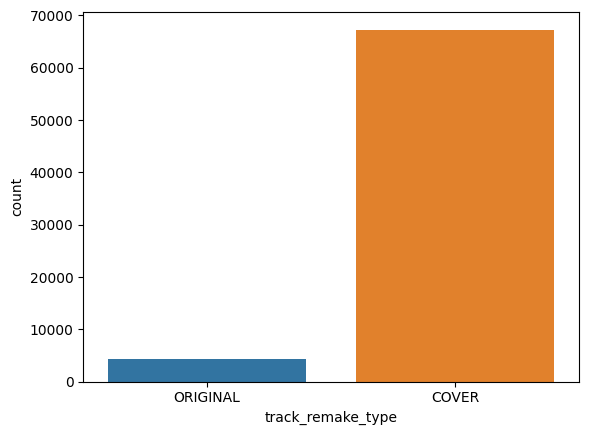

In [10]:
sns.countplot(data=covers, x='track_remake_type')

В файле с разметкой каверов чуть больше 71 тысячи уникальных треков. Информация об оригинальности есть для всех. Оригинальные треки указаны только для части. При этом у всех оригинальных треков указан тот же трек как исходный.

In [11]:
cover_list = covers[(covers['track_remake_type'] == 'COVER') &
                    ~(covers['original_track_id'].isna())]['original_track_id'].tolist()

In [12]:
covers[covers['track_id'].isin(cover_list)]['track_remake_type'].value_counts()

ORIGINAL    53
COVER        3
Name: track_remake_type, dtype: int64

Среди треков помеченных как `COVER` для которых есть ссылки на оригиналы, только 56 имеют ссылку на оригинальный трек, который есть в нашем датасете. Это делает задачу попарного сравнения плохо решаемой.

Информация об оригинальности продублирована для всех треков с меткой `ORIGINAL`. Однако, удалять мы её не станем, она нам поможет при проверке правильности работы нашей модели.

Проверим мета-информацию.

In [13]:
meta = pd.read_json(Path('..', 'data', '01_raw', 'meta.json'), lines=True)

In [14]:
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1639688400000.000,Happy New Year,EN,RUB422103970,[DANCE],161120.000
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1637762433000.000,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.000
2,955f2aafe8717908c140bf122ba4172d,1637768223000.000,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.000
3,fae5a077c9956045955dde02143bd8ff,1637768223000.000,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.000
4,6bede082154d34fc18d9a6744bc95bf5,1637768223000.000,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.000
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1560403209000.000,Chanceuse,FR,CAISO1800023,[INDIE],212690.000
71765,7cba0f30eaa8766d6c203eff2f3750a2,1560432843000.000,Quiero Que Vuelvas,None,ES71G1738868,[POP],237540.000
71766,26b6aca1c6a02ad0e2a939164716657e,1560448202000.000,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.000
71767,d904dda141238e6ad1b428bfbb21262d,1560448202000.000,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.000


In [15]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


Посмотрим на общее количество жанров.

In [16]:
def get_genres(column):
    """
    Функция возвращает уникальные вхождения из определённой колонки.
    """
    genres = []
    for row in column:
        try:
            for entry in row:
                if entry not in genres:
                    genres.append(entry)
        except:
            pass
    return genres

In [17]:
genres = get_genres(meta.genres)

In [18]:
len(genres)

128

In [19]:
meta[meta['track_id'].isna()]

,track_id,dttm,title,language,isrc,genres,duration
44434,None,NaN,None,None,None,None,NaN


In [20]:
meta.drop(index=meta[meta['track_id'].isna()].index, inplace=True)

In [21]:
meta['dttm'] = pd.to_datetime(meta['dttm']/1000, unit='s')

In [22]:
meta.language.value_counts()

EN    15322
ES     1747
RU     1558
IT      907
HI      285
      ...  
KY        1
NY        1
TG        1
ST        1
GN        1
Name: language, Length: 85, dtype: int64

Отсутствует часть информации. Около 3/4 всех меток языка, часть `isrc`. Одна строка пустая. Всего есть информация о треках на 85 языках. Общее количество жанров - 128.

Перевели формат даты в привычный, удалили пустую строку.

Посмотрим на тексты.

In [23]:
lyrics = pd.read_json(Path('..', 'data', '01_raw', 'lyrics.json'), lines=True)

In [24]:
lyrics.head()

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\nПопытками не то любить, что нужно\nТеряю смысл, ну и пусть, невыносимой стала грусть\nИ в комнате, что с потолком мне чужда\n\nЯ б уплыла в океан, сшила б красный сарафан, и... И...\nЯ б забыла, что т...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,"Tell me your fable\nA fable\nTell me your fable\nTell me your fable\nTell me your fable\nA fable\nTell me your fable\nTalk to me, tenderly\nShow reality, fantasy\nWe'll bound together\nAll win in one feat\nTalk to me, tenderly\nShow reality, fant...",0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts\nAnd how I hurt you\nCan you make it back from the aftermath?\nAnd how I left you\nNobody wants to be alone\nWith the fear of letting go\nIf you could hear me say it's gonna be ok\nWould you be ok?\n...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts\nAnd how I hurt you\nCan you make it back from the aftermath?\nAnd how I left you\nNobody wants to be alone\nWith the fear of letting go\nIf you could hear me say it's gonna be ok\nWould you be ok?\n...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm afraid your best wasn't good enough\nAnd know he never wanted you at least not the way\nYou wanted yourself to be loved\nAnd you feel like you were a mistake\nHe's not worth all those tears that won't ...",8d70930d09cd239c948408d1317d8659


In [25]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


Есть некоторое количество дубликатов по `track_id` с разными текстами.

In [26]:
lyrics[(lyrics['track_id'].duplicated(keep=False) == True) &
       (lyrics['text'].duplicated() == False)].sort_values(by='track_id').head(10)

,lyricId,text,track_id
9220,6e3781576e60cfbee15f65d626ac130a,"If I stay with you, if I'm choosing wrong\nI don't care at all\nIf I'm loosing now, but I'm winning late\nThat's all I want\n\nNow we need some space 'cause I feel for you\nAnd I wanna change\nGrowing up alone, it seems so short\nI can't explain\...",0102189356af15ad0be804eddd9bc24a
11306,1682f991cfa94d1440bef2aa417edec7,"If I stay with you, if I'm choosing wrong\nI don't care at all\nIf I'm losing now, but I'm winning late\nThat's all I want\n\nNow we need some space 'cause I feel for you\nAnd I wanna change\nGrowing up alone, it seems so short\nI can't explain\n...",0102189356af15ad0be804eddd9bc24a
4796,9ee5ee7522b5b6d045a2d276a040d00c,"If I stay with you, if I'm choosing wrong\nI don't care at all\nIf I'm losing now, but I'm winning late\nThat's all I want\n\nNow we need some space, 'cause I feel for you\nAnd I wanna change\nGrowing up alone, it seems so short\nI can't explain\...",0102189356af15ad0be804eddd9bc24a
591,bedce0b0814eae28831dfe3013b62dd9,"Well sometimes I go out by myself\nAnd I look across the water\nAnd I think of all the things, what you're doing\nAnd in my head I paint a picture\n\n'Cause since I've come on home\nWell my body's been a mess\nAnd I've missed your ginger hair\nAn...",02db8e8e8d3c08f3a57cc6db3876f942
9392,e4e8784e327f01cfcfbedc1fcfbe8dc9,"Well, sometimes I go out by myself\nAnd I look across the water\nAnd I think of all the things, what you're doing\nAnd in my head I paint a picture\n\n'Cause since I've come on home\nWell, my body's been a mess\nAnd I miss your ginger hair\nAnd t...",02db8e8e8d3c08f3a57cc6db3876f942
8330,52d3570b1f1e50113f10cdd65869614e,"Well sometimes I go out by myself\nAnd I look across the water\nAnd I think of all the things, what you're doing\nAnd in my head I paint a picture\n\nCos since I've come on home,\nWell my body's been a mess\nAnd I've missed your ginger hair\nAnd ...",02db8e8e8d3c08f3a57cc6db3876f942
11307,ea7ee0e977851b765b651b10d20e6ac8,"Hey, little girl, is your daddy home?\nDid he go and leave you all alone?\nI got a bad desire\nOh-oh-oh, I'm on fire\n\nTell me now, baby, is he good to you?\nAnd can he do you the things that I can't do?\nI can take you higher\nOh-oh-oh, I'm on ...",034496119fa3c7afd56db09aa04aca15
4869,160d71605ca3b3f2f1c1c9b335178c80,"Hey little girl, is your daddy home\nDid he go and leave you all alone?\nI got a bad desire\nOh oh oh, I'm on fire\n\nTell me now babe, is he good to you\nCan he do to you the things that I can't do\nI can take you high\nOh oh oh, I'm on fire\n\n...",034496119fa3c7afd56db09aa04aca15
7159,7f31a171e47799a0beb95322797f300a,"Hey girl, is he everything you wanted in a man??\nYou know I gave you the world\nYou had me in the palm of your hand\nSo why your love went away?\nI just can't seem to understand\nThought it was me and you, babe\nMe and you until the end\nBut I g...",03db8e9cd7ff3f1b7835ca8fe31351d1
2255,6f4287d5fc4129025b4823d3bf53f813,"Hey girl, is he everything you wanted in a man?\nYou know I gave you the world\nYou had me in the palm of your hand\nSo why your love went away?\nI just can't seem to understand\nThought it was me and you, babe\nMe and you until the end\nBut I gu...",03db8e9cd7ff3f1b7835ca8fe31351d1


Вероятно, это разные источники для текстов. Не имея возможности выбрать наиболее подходящий для каждого трека, будем использовать первый из них.

## Выводы

Мы осмотрели данные, почистили от явных аномалий. Ознакомились с некоторыми статистиками и особенностями наших данных. Перейдём к проработке стратегий.

# Прямой подход

Данный подход можно охарактеризовать как задачу бинарной классификации на объединённых в единую таблицу данных из наших источников с добавлением признаков и векторных представлений текстов, названий и жанров.

## Подготовка данных

Сделаем копии и проверим данные.

In [27]:
covers_df = covers.copy()
meta_df = meta.copy()
lyrics_df = lyrics.copy()

In [28]:
# проверка
display(covers_df.head(1), meta_df.head(1), lyrics_df.head(1))

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL


,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.000


,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\nПопытками не то любить, что нужно\nТеряю смысл, ну и пусть, невыносимой стала грусть\nИ в комнате, что с потолком мне чужда\n\nЯ б уплыла в океан, сшила б красный сарафан, и... И...\nЯ б забыла, что т...",1c4b1230f937e4c548ff732523214dcd


Напишем функцию для перевода целевого признака к значениям 1/0.

In [29]:
def create_label(row):
    '''
    Функция для формирования целевого признака (далее ЦП).

    '''
    try:
        if row == 'ORIGINAL':
            return 0
        elif row == 'COVER':
            return 1
    except:
        pass

Подготовка данных из файла `covers.json`

In [30]:
# Формируем ЦП в зависимости от значений столбца track_remake_type

covers_df['class_label'] = covers_df['track_remake_type'].apply(create_label)

covers_df.drop(columns='track_remake_type', inplace=True)
covers_df.head(2)

,original_track_id,track_id,class_label
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,0
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,0


In [31]:
# Пропуски в original_track_id заменим на unknown

covers_df['original_track_id'] = covers_df['original_track_id'].fillna('unknown')
covers_df.isna().sum()

original_track_id    0
track_id             0
class_label          0
dtype: int64

Подготовка данных из файла `meta.json`

In [32]:
# Удалим пропуски в столбце dttm и преобразуем тип данных

# обработка пропусков
meta_df = meta_df.dropna(subset=['dttm'])
meta_df.reset_index(drop=True)

meta_df.isna().sum()

track_id        0
dttm            0
title           0
language    49799
isrc          313
genres          0
duration        0
dtype: int64

In [33]:
# преобразование длительности
meta_df['duration'] = (meta_df['duration'] / 1000).round().astype('int64')
meta_df.head()

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203


Функция для очистки текста.

In [34]:
def clear_text(text):
    '''
    Функция для очистки текста от посторонних символов и приведения текста к нижнему регистру.

    '''

    # убираем все знаки препинания, кроме апострофа
    text = re.sub(r'[^\w\s\']', '', text)

    # заменяем символы переноса строки и лишние пробелы на один пробел
    text = re.sub(r'[\n\s]+', ' ', text)

    text = text.lower()

    return text

In [35]:
# преобразование регистра в признаке title, language с помощью функции очистки текста
meta_df['title'] = meta_df['title'].apply(clear_text)
meta_df['language'] = meta_df['language'].fillna('unknown').apply(clear_text)

In [36]:
# преобразование регистра в признаке genres с помощью функции очистки текста
meta_df['genres'] = meta_df['genres'].apply(lambda x: ', '.join(str(y) for y in x))
meta_df['genres'] = meta_df['genres'].apply(clear_text)
meta_df.head()

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,happy new year,en,RUB422103970,dance,161
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,bad habits,en,QZN882178276,electronics,362
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,por esa loca vanidad,unknown,QZNJZ2122549,folk latinfolk,260
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,mil lagrimas,unknown,QZNJZ2166033,folk latinfolk,190
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,sexo humo y alcohol,unknown,QZNJZ2122551,folk latinfolk,203


Подготовка данных из файла `lyrics.json`

In [37]:
# Переименуем столбец lyricId для единообразия стиля наименований признаков

lyrics_df = lyrics_df.rename(columns={'lyricId': 'lyric_id'})

In [38]:
# Проводим очистку текста

lyrics_df['text'] = lyrics_df['text'].apply(clear_text)
lyrics_df.head(2)

,lyric_id,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,живу сейчас обломами обломками не той любви попытками не то любить что нужно теряю смысл ну и пусть невыносимой стала грусть и в комнате что с потолком мне чужда я б уплыла в океан сшила б красный сарафан и и я б забыла что ты есть я б не лезла в...,1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,tell me your fable a fable tell me your fable tell me your fable tell me your fable a fable tell me your fable talk to me tenderly show reality fantasy we'll bound together all win in one feat talk to me tenderly show reality fantasy we'll bound ...,0faea89b0d7d6235b5b74def72511bd8


In [39]:
# Объединим данные в один датафрейм

df = pd.merge(pd.merge(lyrics_df, covers_df, on='track_id'), meta_df, on='track_id')
df.sample(2)

,lyric_id,text,track_id,original_track_id,class_label,dttm,title,language,isrc,genres,duration
4773,c2f6b9d2f750453677db5e4456ffa35f,the world was on fire no one could save me but you it's strange what desire will make foolish people do and i never dreamed that i'd knew somebody like you and i'd never dreamed that i'd need somebody like you and i wanna fall in love this world ...,24546925aa09160b336065943da0161d,unknown,1,2014-02-03 20:00:00,wicked game,en,FIBAR9900322,metal gothicmetal,245
7087,660b04bb26c6239c5b509900ef1ff2ba,let's dance in style let's dance for a while heaven can wait we're only watching the skies hoping for the best but expecting the worst are you gonna drop the bomb or not let us die young or let us live forever we don't have the power but we never...,e9c2e246bd049699e1fc26879fbd0515,unknown,1,2020-10-29 21:00:00,forever young,en,DEE862002593,dance,141


In [40]:
# Проверка наличия явных дубликатов в совокупности признаках track_id, class_label, text'
# Есть дублирующиеся записи по track_id

df[['track_id', 'class_label', 'text']].duplicated().sum()

271

In [41]:
# Удалим дубликаты, оставляя первую запись

df.drop_duplicates(subset=['track_id', 'class_label', 'text'], keep='first', inplace=True)

# проверка
df[['track_id', 'class_label', 'text']].duplicated().sum()

0

In [42]:
# Изменим порядок следования столбцов

df = df[['track_id', 'original_track_id', 'lyric_id', 'isrc',
         'dttm', 'title', 'language', 'genres', 'duration',
         'text', 'class_label']]

In [43]:
def data_info(data_name):
    '''
    Функция для вывода основной информации о данных.

    '''

    print(f'\n\nКоличество признаков: {data_name.shape[1]}, Количество наблюдений: {data_name.shape[0]}\n')
    print(50*'--')

    print('\nИнформация о данных\n')
    info_list = []

    for item in data_name.columns:
        info_list.append({
            'Признак': item,
            'Тип данных': data_name.dtypes[item],
            '%Пропусков': data_name[item].isna().mean()*100
        })

    display(pd.DataFrame(info_list).style.bar(subset=['%Пропусков']))
    print(50*'--')

    print('\n\nОписательные статистики для числовых признаков')
    display(data_name.describe())
    print(50*'--')

    print('\n\nОписательные статистики для остальных признаков')
    display(data_name.describe(include='object').T)

In [44]:
# Финальный просмотр подготовленных данных

data_info(df)



Количество признаков: 11, Количество наблюдений: 10826

----------------------------------------------------------------------------------------------------

Информация о данных



,Признак,Тип данных,%Пропусков
0,track_id,object,0.000000
1,original_track_id,object,0.000000
2,lyric_id,object,0.000000
3,isrc,object,0.692777
4,dttm,datetime64[ns],0.000000
5,title,object,0.000000
6,language,object,0.000000
7,genres,object,0.000000
8,duration,int64,0.000000
9,text,object,0.000000


----------------------------------------------------------------------------------------------------


Описательные статистики для числовых признаков


,duration,class_label
count,10826.000,10826.000
mean,203.911,0.712
std,66.527,0.453
min,0.000,0.000
25%,160.000,0.000
50%,198.000,1.000
75%,236.000,1.000
max,1384.000,1.000


----------------------------------------------------------------------------------------------------


Описательные статистики для остальных признаков


,count,unique,top,freq
track_id,10826,10123,f0f429d03fdd19f08ff60e889e32aae2,8
original_track_id,10826,2825,unknown,7348
lyric_id,10826,10384,28fbafaf626c497d0d4d933b4f0d3f5b,9
isrc,10751,9974,DKUCA0700027,8
title,10826,7562,wicked game,42
language,10826,47,en,4955
genres,10826,175,pop,1954
text,10826,10306,a and x el orfanato danza kuduro lucenzo el orfanato el rey la mano arriba cintura sola da media vuelta danza kuduro no me canses ahora que esto solo empieza mueve la cabeza danza kuduro la mano arriba cintura sola da media vuelta danza kuduro no...,11


### Выводы
На этапе подготовки данных: сформирован ЦП, как метка класса (0 - оригинальный трек, 1 - кавер-трек); проведена минимальная предобработка данных (заполнены пропуски, удалены дубликаты, очищены текстовые данные, скорректированы типы данных). Сформирована основная концепция для дальнейшего построения модели, состоящая в обработке текстовых признаков средствами библиотеки `sentence_transformers`.

## Генерация признаков

Создание признаков год, месяц и число из признака `dttm`.

In [45]:
# Удалим признаки, которые не будем исп. в базовой модели - все идентификаторы и код isrc

df.drop(columns=['track_id', 'original_track_id', 'lyric_id', 'isrc'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.sample(2)

,dttm,title,language,genres,duration,text,class_label
10497,2020-04-07 16:05:56,pra você acreditar,unknown,folk latinfolk,191,limão com mel pensa que eu não reparei que você passou em claro a madrugada inteira quase nem te reconheço revirando do avesso a minha carteira procurando em minhas coisas algo que alimente esse ciúme sem sentido e eu observando tudo e morrendo d...,1
9910,2022-08-26 21:00:00,lemon,ru,pop,255,вот бы осознать что это был всего лишь смутный сон без остатка растворяюсь в тех мечтах где ты со мной на моих воспоминаниях пыль и я опустошён словно чтото взять с собой забыл и вновь бреду домой напоследок ты сумела научить меня тому что исчезн...,1


In [46]:
# Работа с датой - выделение года, месяца и дня в качестве новых признаков
# Удаление признака dttm
df['inform_year'] = df['dttm'].dt.year
df['inform_month'] = df['dttm'].dt.month
df['inform_day'] = df['dttm'].dt.day

df.drop(columns='dttm', inplace=True)
df.head(2)

,title,language,genres,duration,text,class_label,inform_year,inform_month,inform_day
0,сарафан,unknown,foreignbard bard,140,живу сейчас обломами обломками не той любви попытками не то любить что нужно теряю смысл ну и пусть невыносимой стала грусть и в комнате что с потолком мне чужда я б уплыла в океан сшила б красный сарафан и и я б забыла что ты есть я б не лезла в...,0,2018,9,26
1,children,unknown,electronics,215,tell me your fable a fable tell me your fable tell me your fable tell me your fable a fable tell me your fable talk to me tenderly show reality fantasy we'll bound together all win in one feat talk to me tenderly show reality fantasy we'll bound ...,1,2021,8,4


In [47]:
data_info(df)



Количество признаков: 9, Количество наблюдений: 10826

----------------------------------------------------------------------------------------------------

Информация о данных



,Признак,Тип данных,%Пропусков
0,title,object,0.000000
1,language,object,0.000000
2,genres,object,0.000000
3,duration,int64,0.000000
4,text,object,0.000000
5,class_label,int64,0.000000
6,inform_year,int64,0.000000
7,inform_month,int64,0.000000
8,inform_day,int64,0.000000


----------------------------------------------------------------------------------------------------


Описательные статистики для числовых признаков


,duration,class_label,inform_year,inform_month,inform_day
count,10826.000,10826.000,10826.000,10826.000,10826.000
mean,203.911,0.712,2018.567,6.586,16.023
std,66.527,0.453,3.658,3.439,8.946
min,0.000,0.000,2009.000,1.000,1.000
25%,160.000,0.000,2016.000,4.000,9.000
50%,198.000,1.000,2020.000,7.000,16.000
75%,236.000,1.000,2021.000,10.000,24.000
max,1384.000,1.000,2023.000,12.000,31.000


----------------------------------------------------------------------------------------------------


Описательные статистики для остальных признаков


,count,unique,top,freq
title,10826,7562,wicked game,42
language,10826,47,en,4955
genres,10826,175,pop,1954
text,10826,10306,a and x el orfanato danza kuduro lucenzo el orfanato el rey la mano arriba cintura sola da media vuelta danza kuduro no me canses ahora que esto solo empieza mueve la cabeza danza kuduro la mano arriba cintura sola da media vuelta danza kuduro no...,11


In [48]:
# Разделение признаков по группам, по типам данных: числовые и строковые

numerical_features = df.select_dtypes(include=['int64', 'float']).columns.to_list()
numerical_features.remove('class_label')

categorical_features = df.select_dtypes(include=['int32', 'object']).columns.to_list()

# выделим среди категориальных переменных текстовые, для которых будем создавать эмбеддинги
text_features = ['title', 'genres', 'text']

In [49]:
display(numerical_features, categorical_features, text_features)

['duration', 'inform_year', 'inform_month', 'inform_day']

['title', 'language', 'genres', 'text']

['title', 'genres', 'text']

Замечание: несмотря на числовой тип данных в признаках `inform_year`, `inform_month`, `inform_day` далее их стоит рассматривать как категориальные, что более соответствует их смыслу.

Создание эмбеддингов текстовых признаков с помощью трансформера.

In [50]:
%%time
sentences = df['title'].to_list()

model = SentenceTransformer('sentence-transformers/LaBSE')
title_embeddings = model.encode(sentences)

CPU times: total: 18.9 s
Wall time: 15.4 s


In [51]:
title_emb_df = pd.DataFrame(title_embeddings) # для длинного способа указывать embeddings.numpy()

In [52]:
# переименовываем столбцы
title_emb_df = title_emb_df.add_prefix('title_')
title_emb_df.head()

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,title_11,title_12,title_13,title_14,title_15,title_16,title_17,title_18,title_19,title_20,title_21,title_22,title_23,title_24,title_25,title_26,title_27,title_28,title_29,title_30,title_31,title_32,title_33,title_34,title_35,title_36,title_37,title_38,title_39,title_40,title_41,title_42,title_43,title_44,title_45,title_46,title_47,title_48,title_49,title_50,title_51,title_52,title_53,title_54,title_55,title_56,title_57,title_58,title_59,title_60,title_61,title_62,title_63,title_64,title_65,title_66,title_67,title_68,title_69,title_70,title_71,title_72,title_73,title_74,title_75,title_76,title_77,title_78,title_79,title_80,title_81,title_82,title_83,title_84,title_85,title_86,title_87,title_88,title_89,title_90,title_91,title_92,title_93,title_94,title_95,title_96,title_97,title_98,title_99,title_100,title_101,title_102,title_103,title_104,title_105,title_106,title_107,title_108,title_109,title_110,title_111,title_112,title_113,title_114,title_115,title_116,title_117,title_118,title_119,title_120,title_121,title_122,title_123,title_124,title_125,title_126,title_127,title_128,title_129,title_130,title_131,title_132,title_133,title_134,title_135,title_136,title_137,title_138,title_139,title_140,title_141,title_142,title_143,title_144,title_145,title_146,title_147,title_148,title_149,title_150,title_151,title_152,title_153,title_154,title_155,title_156,title_157,title_158,title_159,title_160,title_161,title_162,title_163,title_164,title_165,title_166,title_167,title_168,title_169,title_170,title_171,title_172,title_173,title_174,title_175,title_176,title_177,title_178,title_179,title_180,title_181,title_182,title_183,title_184,title_185,title_186,title_187,title_188,title_189,title_190,title_191,title_192,title_193,title_194,title_195,title_196,title_197,title_198,title_199,title_200,title_201,title_202,title_203,title_204,title_205,title_206,title_207,title_208,title_209,title_210,title_211,title_212,title_213,title_214,title_215,title_216,title_217,title_218,title_219,title_220,title_221,title_222,title_223,title_224,title_225,title_226,title_227,title_228,title_229,title_230,title_231,title_232,title_233,title_234,title_235,title_236,title_237,title_238,title_239,title_240,title_241,title_242,title_243,title_244,title_245,title_246,title_247,title_248,title_249,...,title_518,title_519,title_520,title_521,title_522,title_523,title_524,title_525,title_526,title_527,title_528,title_529,title_530,title_531,title_532,title_533,title_534,title_535,title_536,title_537,title_538,title_539,title_540,title_541,title_542,title_543,title_544,title_545,title_546,title_547,title_548,title_549,title_550,title_551,title_552,title_553,title_554,title_555,title_556,title_557,title_558,title_559,title_560,title_561,title_562,title_563,title_564,title_565,title_566,title_567,title_568,title_569,title_570,title_571,title_572,title_573,title_574,title_575,title_576,title_577,title_578,title_579,title_580,title_581,title_582,title_583,title_584,title_585,title_586,title_587,title_588,title_589,title_590,title_591,title_592,title_593,title_594,title_595,title_596,title_597,title_598,title_599,title_600,title_601,title_602,title_603,title_604,title_605,title_606,title_607,title_608,title_609,title_610,title_611,title_612,title_613,title_614,title_615,title_616,title_617,title_618,title_619,title_620,title_621,title_622,title_623,title_624,title_625,title_626,title_627,title_628,title_629,title_630,title_631,title_632,title_633,title_634,title_635,title_636,title_637,title_638,title_639,title_640,title_641,title_642,title_643,title_644,title_645,title_646,title_647,title_648,title_649,title_650,title_651,title_652,title_653,title_654,title_655,title_656,title_657,title_658,title_659,title_660,title_661,title_662,title_663,title_664,title_665,title_666,title_667,title_668,title_669,title_670,title_671,title_672,title_673,title_674,title_675,title_676,title_677,title

In [53]:
title_emb_df.shape

(10826, 768)

In [54]:
# Объединяем новый датафрейм с исходным датафреймом

df.reset_index(drop=True, inplace=True)
title_emb_df.reset_index(drop=True, inplace=True)

df_emb = pd.concat([df, title_emb_df], axis=1)

# проверка
df_emb.shape

(10826, 777)

In [55]:
%%time
sentences = df['genres'].to_list()

genres_embeddings = model.encode(sentences)

CPU times: total: 6.98 s
Wall time: 6.09 s


In [56]:
genres_emb_df = pd.DataFrame(genres_embeddings) # для длинного способа указывать embeddings.numpy()

In [57]:
# переименовываем столбцы
genres_emb_df = genres_emb_df.add_prefix('genres_')
genres_emb_df.head()

,genres_0,genres_1,genres_2,genres_3,genres_4,genres_5,genres_6,genres_7,genres_8,genres_9,genres_10,genres_11,genres_12,genres_13,genres_14,genres_15,genres_16,genres_17,genres_18,genres_19,genres_20,genres_21,genres_22,genres_23,genres_24,genres_25,genres_26,genres_27,genres_28,genres_29,genres_30,genres_31,genres_32,genres_33,genres_34,genres_35,genres_36,genres_37,genres_38,genres_39,genres_40,genres_41,genres_42,genres_43,genres_44,genres_45,genres_46,genres_47,genres_48,genres_49,genres_50,genres_51,genres_52,genres_53,genres_54,genres_55,genres_56,genres_57,genres_58,genres_59,genres_60,genres_61,genres_62,genres_63,genres_64,genres_65,genres_66,genres_67,genres_68,genres_69,genres_70,genres_71,genres_72,genres_73,genres_74,genres_75,genres_76,genres_77,genres_78,genres_79,genres_80,genres_81,genres_82,genres_83,genres_84,genres_85,genres_86,genres_87,genres_88,genres_89,genres_90,genres_91,genres_92,genres_93,genres_94,genres_95,genres_96,genres_97,genres_98,genres_99,genres_100,genres_101,genres_102,genres_103,genres_104,genres_105,genres_106,genres_107,genres_108,genres_109,genres_110,genres_111,genres_112,genres_113,genres_114,genres_115,genres_116,genres_117,genres_118,genres_119,genres_120,genres_121,genres_122,genres_123,genres_124,genres_125,genres_126,genres_127,genres_128,genres_129,genres_130,genres_131,genres_132,genres_133,genres_134,genres_135,genres_136,genres_137,genres_138,genres_139,genres_140,genres_141,genres_142,genres_143,genres_144,genres_145,genres_146,genres_147,genres_148,genres_149,genres_150,genres_151,genres_152,genres_153,genres_154,genres_155,genres_156,genres_157,genres_158,genres_159,genres_160,genres_161,genres_162,genres_163,genres_164,genres_165,genres_166,genres_167,genres_168,genres_169,genres_170,genres_171,genres_172,genres_173,genres_174,genres_175,genres_176,genres_177,genres_178,genres_179,genres_180,genres_181,genres_182,genres_183,genres_184,genres_185,genres_186,genres_187,genres_188,genres_189,genres_190,genres_191,genres_192,genres_193,genres_194,genres_195,genres_196,genres_197,genres_198,genres_199,genres_200,genres_201,genres_202,genres_203,genres_204,genres_205,genres_206,genres_207,genres_208,genres_209,genres_210,genres_211,genres_212,genres_213,genres_214,genres_215,genres_216,genres_217,genres_218,genres_219,genres_220,genres_221,genres_222,genres_223,genres_224,genres_225,genres_226,genres_227,genres_228,genres_229,genres_230,genres_231,genres_232,genres_233,genres_234,genres_235,genres_236,genres_237,genres_238,genres_239,genres_240,genres_241,genres_242,genres_243,genres_244,genres_245,genres_246,genres_247,genres_248,genres_249,...,genres_518,genres_519,genres_520,genres_521,genres_522,genres_523,genres_524,genres_525,genres_526,genres_527,genres_528,genres_529,genres_530,genres_531,genres_532,genres_533,genres_534,genres_535,genres_536,genres_537,genres_538,genres_539,genres_540,genres_541,genres_542,genres_543,genres_544,genres_545,genres_546,genres_547,genres_548,genres_549,genres_550,genres_551,genres_552,genres_553,genres_554,genres_555,genres_556,genres_557,genres_558,genres_559,genres_560,genres_561,genres_562,genres_563,genres_564,genres_565,genres_566,genres_567,genres_568,genres_569,genres_570,genres_571,genres_572,genres_573,genres_574,genres_575,genres_576,genres_577,genres_578,genres_579,genres_580,genres_581,genres_582,genres_583,genres_584,genres_585,genres_586,genres_587,genres_588,genres_589,genres_590,genres_591,genres_592,genres_593,genres_594,genres_595,genres_596,genres_597,genres_598,genres_599,genres_600,genres_601,genres_602,genres_603,genres_604,genres_605,genres_606,genres_607,genres_608,genres_609,genres_610,genres_611,genres_612,genres_613,genres_614,genres_615,genres_616,genres_617,genres_618,genres_619,genres_620,genres_621,genres_622,genres_623,genres_624,genres_625,genres_626,genres_627,genres_628,genres_629,genres_630,genres_631,genres_632,genres_633,genres_634,genres_635,genres_636,genres_637,genres_638,genres_639,genres_640,ge

In [58]:
# Объединяем новый датафрейм с исходным датафреймом

df_emb.reset_index(drop=True, inplace=True)
genres_emb_df.reset_index(drop=True, inplace=True)

df_emb_genre = pd.concat([df_emb, genres_emb_df], axis=1)

# проверка
df_emb_genre.shape

(10826, 1545)

In [59]:
%%time
sentences = df['text'].to_list()

text_embeddings = model.encode(sentences)

CPU times: total: 3min 41s
Wall time: 3min 29s


In [60]:
text_emb_df = pd.DataFrame(text_embeddings) # для длинного способа указывать embeddings.numpy()

In [61]:
# переименовываем столбцы
text_emb_df = text_emb_df.add_prefix('text_')
text_emb_df.head()

,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10,text_11,text_12,text_13,text_14,text_15,text_16,text_17,text_18,text_19,text_20,text_21,text_22,text_23,text_24,text_25,text_26,text_27,text_28,text_29,text_30,text_31,text_32,text_33,text_34,text_35,text_36,text_37,text_38,text_39,text_40,text_41,text_42,text_43,text_44,text_45,text_46,text_47,text_48,text_49,text_50,text_51,text_52,text_53,text_54,text_55,text_56,text_57,text_58,text_59,text_60,text_61,text_62,text_63,text_64,text_65,text_66,text_67,text_68,text_69,text_70,text_71,text_72,text_73,text_74,text_75,text_76,text_77,text_78,text_79,text_80,text_81,text_82,text_83,text_84,text_85,text_86,text_87,text_88,text_89,text_90,text_91,text_92,text_93,text_94,text_95,text_96,text_97,text_98,text_99,text_100,text_101,text_102,text_103,text_104,text_105,text_106,text_107,text_108,text_109,text_110,text_111,text_112,text_113,text_114,text_115,text_116,text_117,text_118,text_119,text_120,text_121,text_122,text_123,text_124,text_125,text_126,text_127,text_128,text_129,text_130,text_131,text_132,text_133,text_134,text_135,text_136,text_137,text_138,text_139,text_140,text_141,text_142,text_143,text_144,text_145,text_146,text_147,text_148,text_149,text_150,text_151,text_152,text_153,text_154,text_155,text_156,text_157,text_158,text_159,text_160,text_161,text_162,text_163,text_164,text_165,text_166,text_167,text_168,text_169,text_170,text_171,text_172,text_173,text_174,text_175,text_176,text_177,text_178,text_179,text_180,text_181,text_182,text_183,text_184,text_185,text_186,text_187,text_188,text_189,text_190,text_191,text_192,text_193,text_194,text_195,text_196,text_197,text_198,text_199,text_200,text_201,text_202,text_203,text_204,text_205,text_206,text_207,text_208,text_209,text_210,text_211,text_212,text_213,text_214,text_215,text_216,text_217,text_218,text_219,text_220,text_221,text_222,text_223,text_224,text_225,text_226,text_227,text_228,text_229,text_230,text_231,text_232,text_233,text_234,text_235,text_236,text_237,text_238,text_239,text_240,text_241,text_242,text_243,text_244,text_245,text_246,text_247,text_248,text_249,...,text_518,text_519,text_520,text_521,text_522,text_523,text_524,text_525,text_526,text_527,text_528,text_529,text_530,text_531,text_532,text_533,text_534,text_535,text_536,text_537,text_538,text_539,text_540,text_541,text_542,text_543,text_544,text_545,text_546,text_547,text_548,text_549,text_550,text_551,text_552,text_553,text_554,text_555,text_556,text_557,text_558,text_559,text_560,text_561,text_562,text_563,text_564,text_565,text_566,text_567,text_568,text_569,text_570,text_571,text_572,text_573,text_574,text_575,text_576,text_577,text_578,text_579,text_580,text_581,text_582,text_583,text_584,text_585,text_586,text_587,text_588,text_589,text_590,text_591,text_592,text_593,text_594,text_595,text_596,text_597,text_598,text_599,text_600,text_601,text_602,text_603,text_604,text_605,text_606,text_607,text_608,text_609,text_610,text_611,text_612,text_613,text_614,text_615,text_616,text_617,text_618,text_619,text_620,text_621,text_622,text_623,text_624,text_625,text_626,text_627,text_628,text_629,text_630,text_631,text_632,text_633,text_634,text_635,text_636,text_637,text_638,text_639,text_640,text_641,text_642,text_643,text_644,text_645,text_646,text_647,text_648,text_649,text_650,text_651,text_652,text_653,text_654,text_655,text_656,text_657,text_658,text_659,text_660,text_661,text_662,text_663,text_664,text_665,text_666,text_667,text_668,text_669,text_670,text_671,text_672,text_673,text_674,text_675,text_676,text_677,text_678,text_679,text_680,text_681,text_682,text_683,text_684,text_685,text_686,text_687,text_688,text_689,text_690,text_691,text_692,text_693,text_694,text_695,text_696,text_697,text_698,text_699,text_700,text_701,text_702,text_703,text_704,text_705,text_706,text_707,text_708,text_709,text_710,text_711,text_712,text_713,text_714,text_715,text_716,text_717,text_718,text_719,text_720,text_721,text_722,text_723,t

In [62]:
# Объединяем новый датафрейм с исходным датафреймом

df_emb_genre.reset_index(drop=True, inplace=True)
text_emb_df.reset_index(drop=True, inplace=True)

# Объединяем новый датафрейм с исходным датафреймом
df_emb_full = pd.concat([df_emb_genre, text_emb_df], axis=1)
df_emb_full.reset_index(drop=True, inplace=True)

# проверка
df_emb_full.shape

(10826, 2313)

In [63]:
# Удаляем текстовые признаки

df_emb_full.drop(columns=['title', 'genres', 'text'], inplace=True)

# проверка
df_emb_full.shape

(10826, 2310)

### Выводы

На данном этапе были сгенерированы новые признаки и созданы эмбеддинги для текстовых признаков. Сформирован итоговый датафрейм для дальнейшего обучения модели.

## Построение модели

In [64]:
numerical_features = ['duration']
numerical_features

['duration']

In [65]:
categorical_features = df_emb_full.select_dtypes(include=['object']).columns.to_list() + ['inform_year', 'inform_month', 'inform_day']
categorical_features

['language', 'inform_year', 'inform_month', 'inform_day']

In [66]:
# Сохраним признаки и ЦП в отдельных переменных
# Введём обозначения: X - признаки, y - ЦП (по аналогии с обозначениями выборок)

X = df_emb_full.drop(columns=['class_label']) # извлекаем признаки
y = df_emb_full['class_label'] # извлекаем целевой признак

# проверка
display(X.shape, y.shape)

(10826, 2309)

(10826,)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)

# проверка
display(X_train.shape, y_train.shape)
display(X_test.shape, y_test.shape)

(9743, 2309)

(9743,)

(1083, 2309)

(1083,)

Замечание: в процессе формирования эмбеддингов разрослось признаковое пространство, можно было попытаться его уменьшить, путем отбора наиболее важных признаков (feature selection) или изначально попробовать понизить размерность эмбеддингов, исп., например, PCA или FastICA, но не хватило времени для реализации этих идей.

In [68]:
preprocessor = ColumnTransformer(
        [('num_scale', StandardScaler(), numerical_features)],
        remainder='passthrough'
)

cbc_pipeline = Pipeline(
        [('preprocessor', preprocessor),
        ('model', CatBoostClassifier(random_seed=SEED,
                                     cat_features=categorical_features,
                                     eval_metric='F1',
                                     auto_class_weights='Balanced',
                                     verbose=100, task_type='CPU'))]
)

train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=categorical_features)

grid = {'learning_rate': [0.05, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [3, 6],
        'early_stopping_rounds': [10]}


grid_search_result = cbc_pipeline.named_steps['model'].grid_search(grid,
                                                                   train_data)

0:	learn: 0.8062993	test: 0.8077081	best: 0.8077081 (0)	total: 301ms	remaining: 5m
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8238720746
bestIteration = 19

0:	loss: 0.8238721	best: 0.8238721 (0)	total: 3.27s	remaining: 22.9s
0:	learn: 0.8062993	test: 0.8077081	best: 0.8077081 (0)	total: 126ms	remaining: 2m 6s
100:	learn: 0.8830281	test: 0.8719921	best: 0.8719921 (100)	total: 8.25s	remaining: 1m 13s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8814944346
bestIteration = 146

1:	loss: 0.8814944	best: 0.8814944 (1)	total: 16s	remaining: 48.1s
0:	learn: 0.8062993	test: 0.8077081	best: 0.8077081 (0)	total: 109ms	remaining: 1m 48s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.823254448
bestIteration = 19

2:	loss: 0.8232544	best: 0.8814944 (1)	total: 18.6s	remaining: 31s
0:	learn: 0.8062993	test: 0.8077081	best: 0.8077081 (0)	total: 120ms	remaining: 2m
100:	learn: 0.8801357	test: 0.8648578	best: 0.8649027 (92)	total: 8.28

In [69]:
# Оценим качество полученной модели на тестовой выборке.

y_pred = cbc_pipeline.named_steps['model'].predict(X_test)
test_score = f1_score(y_test, y_pred)
print(test_score)

0.9411764705882353


In [70]:
# Параметры "лучшей" модели

cbc_best_params = cbc_pipeline.named_steps['model'].get_params()
cbc_best_params

{'random_seed': 31416,
 'verbose': 100,
 'auto_class_weights': 'Balanced',
 'eval_metric': 'F1',
 'task_type': 'CPU',
 'cat_features': ['language', 'inform_year', 'inform_month', 'inform_day'],
 'depth': 4,
 'od_wait': 10,
 'l2_leaf_reg': 3,
 'learning_rate': 0.1}

In [71]:
# Анализ важности признаков

fi = pd.DataFrame({'feature_names': cbc_pipeline.named_steps['model'].feature_names_,
                   'importance': cbc_pipeline.named_steps['model'].feature_importances_})
fi = fi.sort_values(by='importance', ascending=False)

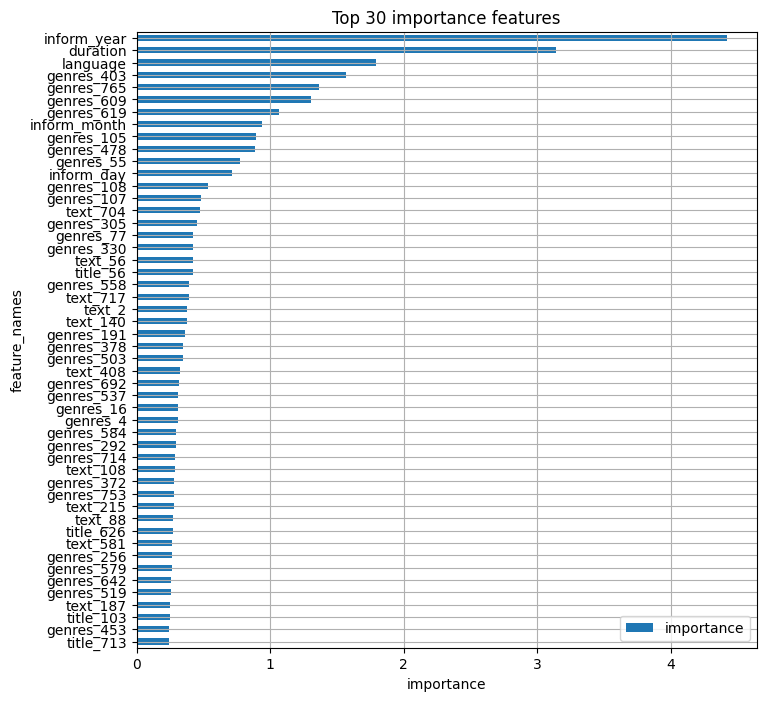

In [72]:
# Визуализация

features_rate = fi.set_index('feature_names', drop=True)
features_rate.head(50).sort_values(by='importance').plot(kind='barh', grid=True, figsize=(8, 8))
plt.title('Top 30 importance features')
plt.xlabel('importance');

In [73]:
def get_metrics(y_test, y_predicted):
    '''
    Функция для вывода значимых метрик (взвешенных).

    '''

    # TP / (TP + FP)
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')

    # TP / (TP + FN)
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')

    # гармоническое среднее значение точности (precision) и полноты (recall)
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    #f1 = f1_score(y_test, y_predicted)

    # (TP + TN) / total
    accuracy = accuracy_score(y_test, y_predicted)

    return accuracy, precision, recall, f1

In [74]:
# Вывод метрик (взвешенных)

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print(f'precision = {round(precision, 4)}, recall = {round(recall, 4)}')
print(f'accuracy = {round(accuracy, 4)}, f1 = {round(f1, 4)}')

precision = 0.9156, recall = 0.916
accuracy = 0.916, f1 = 0.9158


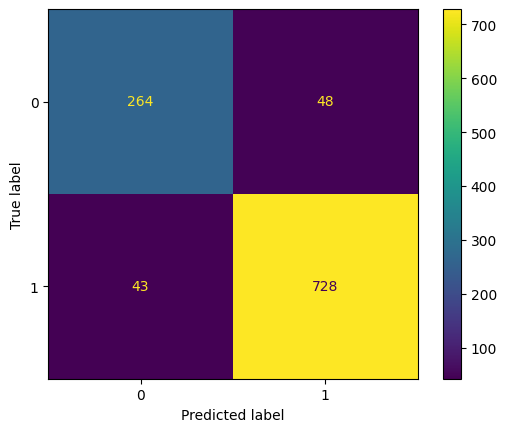

In [75]:
# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred, labels=cbc_pipeline.named_steps['model'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cbc_pipeline.named_steps['model'].classes_)
disp.plot()
plt.show()

### Выводы:

На основе матрицы ошибок и метрик качества, можно сделать следующие выводы о модели:

- модель имеет высокую точность и полноту, что говорит о том, что она правильно классифицирует большую часть примеров;

- `F1-мера` (0.94) также показывает хорошую сбалансированность между точностью и полнотой модели.

Для более объективной оценки модели, с учётом наличия дисбаланса классов, вычислены взвешенные метрики, значения которых, в целом, также указывают на хорошее качество модели.

# Попарное сравнение треков

## Feature engineering

Объединим информацию из разных источников в единую сводную таблицу.

In [76]:
df = pd.merge(covers, meta, how='left', on='track_id')
df = pd.merge(df, lyrics, how='left', on='track_id')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  5378 non-null   object        
 1   track_id           72571 non-null  object        
 2   track_remake_type  72571 non-null  object        
 3   dttm               72571 non-null  datetime64[ns]
 4   title              72571 non-null  object        
 5   language           22598 non-null  object        
 6   isrc               72242 non-null  object        
 7   genres             72571 non-null  object        
 8   duration           72571 non-null  float64       
 9   lyricId            11097 non-null  object        
 10  text               11097 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 6.6+ MB


In [78]:
df.head()

,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,lyricId,text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.000,260f21d9f48e8de874a6e844159ddf28,"Left a good job in the city\nWorkin' for the man ev'ry night and day\nAnd I never lost one minute of sleepin'\nWorryin' 'bout the way things might have been\n\nBig wheel keep on turnin'\nProud Mary keep on burnin'\nRollin', rollin', rollin' on th..."
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.000,f3331cf99637ee24559242d13d8cf259,"Left a good job in the city\nWorkin' for the man every night and day\nAnd I never lost one minute of sleepin'\nWorryin' 'bout the way things might have been\n\nBig wheel keep on turnin'\nProud Mary keep on burnin'\nRollin', rollin'\nRollin' on th..."
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2009-11-11 21:00:00,Fortunate Son,EN,USFI86900065,"[ROCK, ALLROCK]",137780.000,2498827bd11eca5846270487e4960080,"Some folks are born made to wave the flag\nOoh, they're red, white and blue\nAnd when the band plays ""Hail to the Chief""\nOoh, they point the cannon at you, Lord\n\nIt ain't me, it ain't me\nI ain't no senator's son, son\nIt ain't me, it ain't me..."
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,2009-09-21 20:00:00,La Camisa Negra,ES,USUL10400965,"[POP, FOLK, LATINFOLK]",216840.000,5237001311d4062bf2b80de30652bf58,"Uno por pobre y feo, hombre\nPero antoja'o, ay ome\n\nTengo la camisa negra\nHoy mi amor está de luto\nHoy tengo en el alma una pena\nY es por culpa de tu embrujo\n\nHoy sé que tú ya no me quieres\nY eso es lo que más me hiere\nQue tengo la camis..."
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,The Way I Are,EN,USUM70722806,"[FOREIGNRAP, RAP]",179660.000,e5b1b57090b728e8d98d2b4d9b781bf4,"Yeah!... yeah!... remember the time, baby... yeah!\n\nI ain't got no money\nI ain't got no car to take you on a date\nI can't even buy you flowers\nBut together we'd be the perfect soulmates\nTalk to me girl\n\n(Oh) Baby, it's alright now, you ai..."


В связи с выбранной стратегией - наша первая задача - получить векторные представления для треков к которым есть тексты. Поэтому сначала почистим полученный датасет. Избавимся от треков к которым нет текстов.

In [79]:
df.dropna(subset=['text'], inplace=True)

Избавимся от неинформативных столбцов, повторов по `track_id`.

In [80]:
df.drop(columns=['isrc', 'genres', 'lyricId'], inplace=True)

In [81]:
df.drop_duplicates(subset=['track_id'], inplace=True, ignore_index=True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10123 entries, 0 to 10122
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  3042 non-null   object        
 1   track_id           10123 non-null  object        
 2   track_remake_type  10123 non-null  object        
 3   dttm               10123 non-null  datetime64[ns]
 4   title              10123 non-null  object        
 5   language           6297 non-null   object        
 6   duration           10123 non-null  float64       
 7   text               10123 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 632.8+ KB


<AxesSubplot:xlabel='track_remake_type', ylabel='count'>

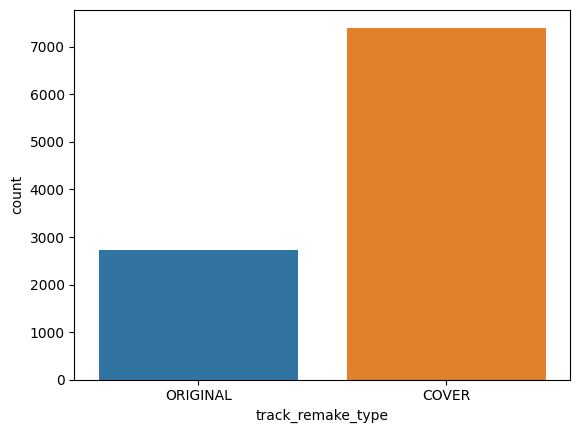

In [83]:
sns.countplot(data=df, x='track_remake_type')

Обработаем тексты. Для начала очистим их и переведём в единый регистр.

In [84]:
def cleaning(row):
    text = re.sub('[^a-zA-Z\'\u00C0-\u1FFF\u2C00-\uD7FF\w]', ' ', row['text']).lower().strip()
    title = re.sub('[^a-zA-Z\'\u00C0-\u1FFF\u2C00-\uD7FF\w]', ' ', row['title']).lower().strip()
    row['text'] = text
    row['title'] = title
    return row

df = df.apply(cleaning, axis=1)

Соберём все тексты в списки.

In [85]:
texts = df['text'].to_list()
titles = df['title'].to_list()
print(len(texts), len(titles))

10123 10123


Убедимся что GPU доступна.

In [86]:
print('torch.cuda.is_available() ', torch.cuda.is_available())
print('torch.cuda.current_device() ', torch.cuda.current_device())
print('torch.cuda.device_count()', torch.cuda.device_count())
print('torch.cuda.get_device_name(0)', torch.cuda.get_device_name(0))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
None

torch.cuda.is_available()  True
torch.cuda.current_device()  0
torch.cuda.device_count() 1
torch.cuda.get_device_name(0) NVIDIA GeForce GTX 970
cuda:0


Загрузим модель LaBSE. В основе трансформер BERT обученный на 109 языках.

In [87]:
model = SentenceTransformer('sentence-transformers/LaBSE')

Получим эмбеддинги.

In [88]:
%%time
embeddings = model.encode(texts)
title_embeddings = model.encode(titles)

CPU times: total: 3min 36s
Wall time: 3min 23s


In [89]:
torch.cuda.empty_cache()
None

In [90]:
embeddings.shape

(10123, 768)

In [91]:
title_embeddings.shape

(10123, 768)

Присоединим энкодинги к датасету.

In [92]:
df['embeddings'] = embeddings.tolist()
df['title_embeddings'] = title_embeddings.tolist()

Проверим результат.

In [93]:
df.head()

,original_track_id,track_id,track_remake_type,dttm,title,language,duration,text,embeddings,title_embeddings
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,2009-11-11 21:00:00,proud mary,EN,187220.000,left a good job in the city workin' for the man ev'ry night and day and i never lost one minute of sleepin' worryin' 'bout the way things might have been big wheel keep on turnin' proud mary keep on burnin' rollin' rollin' rollin' on the river...,"[-0.050590965896844864, 0.012209675274789333, 0.001305880374275148, -0.07543127238750458, -0.00678922887891531, 0.006507829297333956, -0.054885830730199814, -0.02974664606153965, 0.03764769062399864, -0.013026924803853035, -0.028788456693291664, ...","[0.015319151803851128, -0.020575083792209625, 0.04910973459482193, -0.049113448709249496, 0.008503860794007778, -0.011785788461565971, -0.015698367729783058, 0.034062594175338745, -0.027196429669857025, 0.0039495015516877174, -0.01361836865544319..."
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2009-11-11 21:00:00,fortunate son,EN,137780.000,some folks are born made to wave the flag ooh they're red white and blue and when the band plays hail to the chief ooh they point the cannon at you lord it ain't me it ain't me i ain't no senator's son son it ain't me it ain't me i ain'...,"[-0.027721567079424858, 0.01549859531223774, -0.02412036992609501, -0.05025006830692291, -0.027913503348827362, 0.017961055040359497, -0.029539937153458595, -0.025898190215229988, 0.011355213820934296, -0.017320213839411736, 0.009613011963665485,...","[-0.04015070199966431, -0.007268587592989206, -0.0357542559504509, -0.038561392575502396, 0.002995580667629838, 0.02151617407798767, 0.003989551216363907, -0.004519234877079725, -0.06443610042333603, -0.04865966737270355, 0.008546262048184872, 0...."
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,2009-09-21 20:00:00,la camisa negra,ES,216840.000,uno por pobre y feo hombre pero antoja'o ay ome tengo la camisa negra hoy mi amor está de luto hoy tengo en el alma una pena y es por culpa de tu embrujo hoy sé que tú ya no me quieres y eso es lo que más me hiere que tengo la camisa negra y ...,"[-0.04280870780348778, -0.0458928607404232, -0.023140158504247665, -0.06842359155416489, -0.010640840977430344, 0.00496312603354454, -0.0626155287027359, 0.002434623194858432, 0.035209521651268005, -0.030234551057219505, 0.0193279217928648, -0.03...","[-0.03399386629462242, -0.0004971372545696795, 0.01695762760937214, -0.05621883645653725, 0.0514611080288887, 0.023097459226846695, 0.006508655846118927, 0.04137822240591049, -0.04644152149558067, -0.029503053054213524, 0.03082728013396263, -0.03..."
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,2009-11-16 21:00:00,the way i are,EN,179660.000,yeah yeah remember the time baby yeah i ain't got no money i ain't got no car to take you on a date i can't even buy you flowers but together we'd be the perfect soulmates talk to me girl oh baby it's alright now you ain't gott...,"[-0.011799679137766361, 0.0051587666384875774, -0.06203089654445648, -0.0674506425857544, 0.0027503950987011194, 0.03172148019075394, -0.06496895849704742, 0.016190633177757263, -0.020558254793286324, -0.04381493479013443, 0.034264106303453445, -...","[-0.020926419645547867, -0.012833914719522, -0.053437333554029465, -0.057744789868593216, 0.04365824535489082, -0.02771497704088688, 0.01882927119731903, -0.0041795880533754826, -0.06583704799413681, 0.024439938366413116, 0.04783844202756882, -0...."
4,None,4da9d7b6d119db4d2d564a2197798380,COVER,2009-09-17 20:00:00,can't buy me love,EN,158950.000,can't buy me love can't buy me love can't buy me love i'll buy you a diamond ring my friend if it makes you feel alright i'll get you anything my friend if it makes you feel alright for i don't care too much for money for money can't buy me lo...,"[-0.026195090264081955, -0.020733783021569252, -0.0517747700214386,

Отберём треки для составления пар.

In [94]:
cover_list = df[(df['track_remake_type'] == 'COVER') &
                    ~(df['original_track_id'].isna())]['original_track_id'].tolist()

In [95]:
df[df['track_id'].isin(cover_list)]['track_remake_type'].value_counts()

ORIGINAL    43
COVER        2
Name: track_remake_type, dtype: int64

В датасете осталось всего 45 треков про которые точно известно что они являются каверами и при этом у нас есть текст оригинального трека. Что позволит сравнить данные треки с меткой `is_cover` = 1. При этом у нас есть метка `ORIGINAL` что по утверждению заказчика говорит о том что в цепочке каверов данный трек точно определён как исходный. Таким образом сравнивая треки с меткой `ORIGINAL` друг с другом мы можем быть уверены что они не являются каверами друг друга и проставить для них метку `is_cover` = 0. Соберём такой датасет.

Возьмём индексы треков являющихся каверами и имеющих ссылки на оригинальные треки.

In [96]:
cover = set(df[(df['track_remake_type'] == 'COVER')
               & ~(df['original_track_id'].isna())].index)
len(cover)

325

Также выберем индексы треков которые являются оригиналами к вышеперечисленным трекам.

In [97]:
originals_to_cover = set(df[df['track_id'].isin(cover_list)].index)
len(originals_to_cover)

45

Получим пары у которых можно проставить метку `is_cover` = 1. Отберём среди оригинальных треков в 9 раз большее количество не совпадающих с ране помеченными треками.

Выберем все треки, являющиеся не оригиналами.

In [98]:
non_originals = set(df[(df['track_remake_type'] == 'COVER')].index)
len(non_originals)

7406

Выберем треки которые можно использовать для составления пар с меткой `is_cover` = 0.

In [99]:
originals = set(df.index) - cover - originals_to_cover - non_originals
len(originals)

2674

Составим таблицу из пар треков являющихся друг другу каверами.

In [100]:
pairs = df.loc[cover]

In [101]:
pairs = pd.merge(pairs, df, how='left', left_on='original_track_id', right_on='track_id', suffixes=['_first', '_second'])
pairs.dropna(inplace=True)
pairs['is_cover'] = 1

In [102]:
pairs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 323
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   original_track_id_first   143 non-null    object        
 1   track_id_first            143 non-null    object        
 2   track_remake_type_first   143 non-null    object        
 3   dttm_first                143 non-null    datetime64[ns]
 4   title_first               143 non-null    object        
 5   language_first            143 non-null    object        
 6   duration_first            143 non-null    float64       
 7   text_first                143 non-null    object        
 8   embeddings_first          143 non-null    object        
 9   title_embeddings_first    143 non-null    object        
 10  original_track_id_second  143 non-null    object        
 11  track_id_second           143 non-null    object        
 12  track_remake_type_seco

Получили 143 пары. Теперь составим пары из оригинальных треков.

Т.к. датасет синтетический, нам надо постараться сохранить соотношение классов в разумном коридоре. Из открытых источников известно что доля каверов составляет от 5 до 30 % от всех треков. Для увеличения размера выборки возьмём нижнюю границу.

In [103]:
pairs_original = df.loc[originals].reset_index(drop=True)
pairs_original = pairs_original.join(
    other=pairs_original.sample(frac=1, random_state=SEED).reset_index(drop=True),
    lsuffix='_first',
    rsuffix='_second'
)
pairs_original = pairs_original[pairs_original['track_id_first'] != pairs_original['track_id_second']]
pairs_original['is_cover'] = 0

In [104]:
pairs_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2673 entries, 0 to 2673
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   original_track_id_first   2673 non-null   object        
 1   track_id_first            2673 non-null   object        
 2   track_remake_type_first   2673 non-null   object        
 3   dttm_first                2673 non-null   datetime64[ns]
 4   title_first               2673 non-null   object        
 5   language_first            1697 non-null   object        
 6   duration_first            2673 non-null   float64       
 7   text_first                2673 non-null   object        
 8   embeddings_first          2673 non-null   object        
 9   title_embeddings_first    2673 non-null   object        
 10  original_track_id_second  2673 non-null   object        
 11  track_id_second           2673 non-null   object        
 12  track_remake_type_se

Объединим их.

In [105]:
data = pd.concat([pairs, pairs_original]).reset_index(drop=True)

In [106]:
data.head()

,original_track_id_first,track_id_first,track_remake_type_first,dttm_first,title_first,language_first,duration_first,text_first,embeddings_first,title_embeddings_first,original_track_id_second,track_id_second,track_remake_type_second,dttm_second,title_second,language_second,duration_second,text_second,embeddings_second,title_embeddings_second,is_cover
0,ad1b9fe17c16ab73b2a52920fdb1a220,64e605a50d55d71a9e1c8be33bf6020a,COVER,2014-11-19 17:55:40,valerie,SV,236120.000,well sometimes i go out by myself and i look across the water and i think of all the things what you're doing and in my head i paint a picture 'cause since i've come on home well my body's been a mess and i've missed your ginger hair and the w...,"[-0.044756677001714706, -0.05254136025905609, -0.004346932750195265, -0.07322010397911072, -0.016460340470075607, -0.04337234050035477, -0.059935543686151505, 0.021381380036473274, 0.006468093954026699, -0.04183240234851837, -0.001160806044936180...","[0.011244205757975578, -0.03172340244054794, 0.05158513784408569, -0.020744644105434418, 0.01249606627970934, -0.00954363401979208, -0.009239035658538342, 0.020595842972397804, -0.049346163868904114, 0.012199626304209232, -0.02764236368238926, -0...",ad1b9fe17c16ab73b2a52920fdb1a220,ad1b9fe17c16ab73b2a52920fdb1a220,ORIGINAL,2014-02-03 20:00:00,valerie,EN,236260.000,well sometimes i go out by myself and i look across the water and i think of all the things what you do and in my head i make a picture 'cause since i've come on home well my body's been a mess and i've missed your ginger hair and the way yo...,"[-0.04360475763678551, -0.053058452904224396, -0.0033517922274768353, -0.0746745839715004, -0.01717943139374256, -0.042378995567560196, -0.06078696250915527, 0.01781575009226799, 0.002817784436047077, -0.046716924756765366, -0.001228715875186026,...","[0.011244205757975578, -0.03172340244054794, 0.05158513784408569, -0.020744644105434418, 0.01249606627970934, -0.00954363401979208, -0.009239035658538342, 0.020595842972397804, -0.049346163868904114, 0.012199626304209232, -0.02764236368238926, -0...",1
1,b9213d37c37deffe8b8af0dac5d0c3c4,58a293c4c86b4c0000b0e683c77432a8,COVER,2009-09-17 20:00:00,everlasting love,EN,182860.000,hearts go astray leaving hurt when they go i went away just when you needed me so filled with regret i come back beggin' you forgive forget where's the love we once knew open up your eyes then you'll realize here i stand with my everlasti...,"[-0.017863217741250992, -0.05045800656080246, -0.014154268428683281, -0.06852192431688309, -0.006179174408316612, 0.03249577805399895, -0.06675302982330322, 0.021933794021606445, 0.0016984520480036736, 0.010259768925607204, 0.000535291968844831, ...","[-0.023095859214663506, -0.06139333173632622, -0.006027283612638712, -0.0323810800909996, 0.060780249536037445, 0.04837876185774803, -0.026886504143476486, -0.006193656474351883, -0.029432492330670357, 0.006021825131028891, -0.021831469610333443,...",b9213d37c37deffe8b8af0dac5d0c3c4,b9213d37c37deffe8b8af0dac5d0c3c4,ORIGINAL,2019-02-09 19:25:52,everlasting love,EN,178600.000,hearts go astray leaving hurt when they go i went away just when you you needed me so filled with regret i come back begging you won't you forget welcome love we once knew open up your eyes then you'll realize here i stand with my everlas...,"[-0.0076004560105502605, -0.045053452253341675, -0.014730497263371944, -0.06650989502668381, 0.008491424843668938, 0.03359537199139595, -0.06641265004873276, 0.029122622683644295, 0.008924299851059914, 0.014808004721999168, -0.005642336327582598,...","[-0.023095859214663506, -0.06139333173632622, -0.006027283612638712, -0.0323810800909996, 0.060780249536037445, 0.04837876185774803, -0.026886504143476486, -0.006193656474351883, -0.029432492330670357, 0.006021825131028891, -0.021831469610333443,...",1
2,deb9b9598176a0bab1212d430b10bd04,bfa9c5c62c08a0db763e2a2284e3d1b2,COVER,2009-09-17 20:00:00,sweet dreams are made of this,EN,293380.000,sweet dreams are made of thi

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2816 entries, 0 to 2815
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   original_track_id_first   2816 non-null   object        
 1   track_id_first            2816 non-null   object        
 2   track_remake_type_first   2816 non-null   object        
 3   dttm_first                2816 non-null   datetime64[ns]
 4   title_first               2816 non-null   object        
 5   language_first            1840 non-null   object        
 6   duration_first            2816 non-null   float64       
 7   text_first                2816 non-null   object        
 8   embeddings_first          2816 non-null   object        
 9   title_embeddings_first    2816 non-null   object        
 10  original_track_id_second  2816 non-null   object        
 11  track_id_second           2816 non-null   object        
 12  track_remake_type_se

Создадим для каждой пары признаки сходства языков.

In [108]:
data['language_unknown'] = (data['language_first'].isna() | data['language_second'].isna()).astype(int)
data['same_language'] = (data['language_first'] == data['language_second']).astype(int)

Посчитаем косинусные меры близости между текстами и названиями пар треков, добавим в данные.

In [109]:
data['text_similarity'] = cosine_similarity(
    data['embeddings_first'].tolist(),
    data['embeddings_second'].tolist()
).diagonal()
data['title_similarity'] = cosine_similarity(
    data['title_embeddings_first'].tolist(),
    data['title_embeddings_second'].tolist()
).diagonal()

### Выводы

Мы объединили исходные данные в единую таблицу. Почистили данные. Очистили и привели к единому формату тексты песен. Запустили нечуствительную к языку модель на GPU и создали эмбеддинги для текстов.

Создали набор данных подходящий для обучения по выбранной стратегии и сгенерировали некоторые признаки. Теперь можно приступать к обучению моделей.

## Обучение моделей

В данном случае мы решаем задачу бинарной классификации с целевой меткой кавер/не кавер. Для бизнеса важно как можно более точное нахождение пула каверов к некоторому треку, в таком случае можно было бы использовать recall в качестве метрики качества моделей, однако, в связи с сильным дисбалансом возможно ненужное смещение оценок в пользу каверов. В качестве метрики будем использовать гармоническое среднее между точностью и полнотой.

Выделим из полученных данных те что нужны для обучения и создадим обучающую и тестовые выборки.

In [110]:
X = data[['duration_first', 'duration_second',
          'same_language', 'language_unknown',
          'text_similarity', 'title_similarity']]
y = data['is_cover']

X, X_test, y, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

### LogisticRegression

В качестве базового алгоритма выберем логистическую регрессию. Создадим pipeline с применением StandardScaler для числовых признаков.

In [111]:
linear_transformer = make_column_transformer(
    (
        StandardScaler(
        ), make_column_selector(dtype_include='float')
    ),
    remainder='passthrough'
)

Соберём pipeline для логистической регрессии.

In [112]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим estimator.

In [113]:
param_grid = {
    'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__C':[.0001, .001, .01, .1, 1, 10, 100, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [114]:
%time gs_lr.fit(X, y)
None

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: total: 562 ms
Wall time: 3.7 s


Проверим результаты.

In [115]:
pd.DataFrame(gs_lr.cv_results_)[[
    'param_logisticregression__C',
    'param_logisticregression__solver', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(10)

,param_logisticregression__C,param_logisticregression__solver,mean_test_score,rank_test_score
0,0.000,newton-cg,0.986,1
37,1000,liblinear,0.986,1
33,100,sag,0.986,1
32,100,liblinear,0.986,1
31,100,lbfgs,0.986,1
30,100,newton-cg,0.986,1
38,1000,sag,0.986,1
18,0.100,sag,0.986,1
16,0.100,lbfgs,0.986,1
15,0.100,newton-cg,0.986,1


In [116]:
gs_lr.best_score_

0.9857994579945799

При сравнении эмбеддингов текстов, даже простая логистическая регрессия показала хороший результат. Попробуем SVM.

### Модель LinearSVC.

Создадим pipeline для модели.

In [117]:
pipe_lsvc = make_pipeline(
    linear_transformer,
    LinearSVC(
        class_weight='balanced',
        random_state=SEED
    )
)

Зададим сетку параметров и создадим estimator.

In [118]:
param_grid = {
    'linearsvc__loss':['hinge', 'squared_hinge'],
    'linearsvc__C':[.0001, .001, .01, .1, 1, 10, 100, 1000]
}

gs_lsvc = GridSearchCV(
    pipe_lsvc,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [119]:
%time gs_lsvc.fit(X, y)
None

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 141 ms
Wall time: 260 ms


C:\Users\brovk\anaconda3\envs\practicum\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Проверим результаты.

In [120]:
pd.DataFrame(gs_lsvc.cv_results_)[[
    'param_linearsvc__loss',
    'param_linearsvc__C', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(10)

,param_linearsvc__loss,param_linearsvc__C,mean_test_score,rank_test_score
11,squared_hinge,10,0.986,1
13,squared_hinge,100,0.986,1
10,hinge,10,0.981,3
6,hinge,0.100,0.981,4
14,hinge,1000,0.981,5
15,squared_hinge,1000,0.981,5
4,hinge,0.010,0.977,7
5,squared_hinge,0.010,0.977,7
8,hinge,1,0.977,9
9,squared_hinge,1,0.977,9


In [121]:
gs_lsvc.best_score_

0.9857994579945799

Аналогичный результат. В конце попробуем градиентный бустинг.

### CatBoostClassifier

Создадим модель.

In [122]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=SEED,
    early_stopping_rounds=5,
    cat_features=['same_language', 'language_unknown'],
    verbose=0
)

Зададим словарь для писка оптимальных гиперпараметров.

In [123]:
param_grid = {
    'learning_rate': [.1, .5, 1],
    'depth': [2, 3, 4, 5, 6]
}
              
gs_cb = GridSearchCV(
    model,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=0,
    refit='f1'
)

Проведём подбор параметров.

In [124]:
%time gs_cb.fit(X, y)
None

CPU times: total: 531 ms
Wall time: 3.8 s


Проверим результаты.

In [125]:
pd.DataFrame(gs_cb.cv_results_)[[
    'param_learning_rate',
    'param_depth', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(10)

,param_learning_rate,param_depth,mean_test_score,rank_test_score
4,0.500,3,0.990,1
0,0.100,2,0.985,2
3,0.100,3,0.985,2
7,0.500,4,0.985,2
8,1,4,0.985,2
9,0.100,5,0.985,2
10,0.500,5,0.985,2
12,0.100,6,0.985,2
13,0.500,6,0.985,2
2,1,2,0.981,10


In [126]:
gs_cb.best_score_

0.9902439024390244

Результат чуть лучше SVM.

Проведём проверку лучшей модели на тестовой выборке.

In [127]:
predictions_test = gs_cb.predict(X_test)
cr = classification_report(y_test, predictions_test, output_dict=True, zero_division=0)
display(pd.DataFrame(cr).round(decimals=3).transpose())

,precision,recall,f1-score,support
0,0.999,1.000,0.999,668.000
1,1.000,0.972,0.986,36.000
accuracy,0.999,0.999,0.999,0.999
macro avg,0.999,0.986,0.993,704.000
weighted avg,0.999,0.999,0.999,704.000


Также визуализируем.

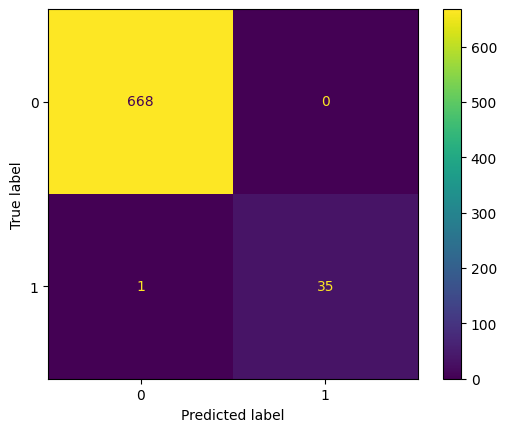

In [128]:
cm = confusion_matrix(y_test, predictions_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()

Посмотрим на то единственный трек, который модели не признали кавером.

In [129]:
data.iloc[
    (y_test != predictions_test)[(y_test != predictions_test) == True].index
]

,original_track_id_first,track_id_first,track_remake_type_first,dttm_first,title_first,language_first,duration_first,text_first,embeddings_first,title_embeddings_first,original_track_id_second,track_id_second,track_remake_type_second,dttm_second,title_second,language_second,duration_second,text_second,embeddings_second,title_embeddings_second,is_cover,language_unknown,same_language,text_similarity,title_similarity
33,d23bd7aaa8aae3c60b431d45eafe9cb4,d77d5f78b553751a893f4eab0dbe5437,COVER,2021-03-15 12:11:49,белые крылья,RU,134180.000,дайте мне белые крылья я утопаю в омуте через тернии провода в небо только б не мучаться дайте мне белые крылья я утопаю в омуте через тернии провода в небо только б не мучаться тучкой маленькой обернусь и над твоим крохотны...,"[-0.054874926805496216, -0.04738309234380722, -0.02423044852912426, -0.07477065920829773, -0.010576612316071987, 0.03659221902489662, -0.05939880758523941, -0.028331924229860306, -0.013450082391500473, 0.017253659665584564, 0.028974134474992752, ...","[0.02957996353507042, -0.03239593654870987, -0.023814812302589417, -0.04001777619123459, 0.014775223098695278, 0.018748192116618156, -0.054251912981271744, -0.012371303513646126, -0.04867536202073097, -0.04400248825550079, -0.01826295629143715, -...",d23bd7aaa8aae3c60b431d45eafe9cb4,d23bd7aaa8aae3c60b431d45eafe9cb4,ORIGINAL,2022-10-27 21:00:00,я так соскучился,RU,408870.000,город расколется на мириады зеркал рвутся в любовных пожарах петарды сердец стенка за стенкой душа за душою тоска тянет в болотную топь заколдованных мест я же тебя никогда никому не отдам пело сердечко и плакали гордые льды наши тела бы могли...,"[-0.04521183297038078, -0.0028041969053447247, 0.0025766505859792233, -0.07152652740478516, 0.04110591486096382, 0.048111166805028915, -0.059831999242305756, -0.011143587529659271, -0.00011979886039625853, 0.016346866264939308, 0.0268500056117773...","[-0.03063390403985977, -0.053099967539310455, -0.03432947397232056, -0.06303263455629349, -0.04628288000822067, -0.023743776604533195, -0.00025596952764317393, -0.038573190569877625, -0.04952862486243248, -0.010214222595095634, 0.0155485291033983...",1,0,1,0.649,0.342


Названия отличаются, поэтому косинусная близость маленькая. Посмотрим на тексты песен.

In [130]:
data.iloc[33]['text_first']

'дайте мне белые крылья    я утопаю в омуте  через тернии  провода    в небо  только б не мучаться   дайте мне белые крылья    я утопаю в омуте  через тернии  провода    в небо  только б не мучаться   тучкой маленькой обернусь и над твоим крохотным домиком разрыдаюсь косым дождем  знаешь  я так соскучился'

In [131]:
data.iloc[33]['text_second']

'город расколется на мириады зеркал рвутся в любовных пожарах петарды сердец стенка за стенкой  душа  за душою тоска тянет в болотную топь заколдованных мест  я же тебя никогда никому не отдам пело сердечко и плакали гордые льды наши тела бы могли отыскать по следам если бы мы не забыли оставить следы  дайте мне белые крылья  я утопаю в омуте через тернии  провода  в небо  только б не мучиться тучкой маленькой обернусь и над твоим крохотным домиком разрыдаюсь косым дождём  знаешь  я так соскучился   знаешь  я так соскучился  знаешь  я так соскучился  знаешь  я так соскучился  знаешь  встретимся и за секунду проносится ночь но вечностью чёрной разлука обрушится вновь так почему же мы всё разбегаемся прочь зная в каком направлении наша любовь   мы друг для друга давно стали как зеркала видеть тебя и всё чаще себя узнавать нитью незримой нас намертво сшила игла так больно  когда города нас хотят разорвать  дайте мне белые крылья  я утопаю в омуте через тернии  провода  в небо  только б не

В целом прослеживаются определённые схожие фрагменты, но нужно прослушать оба трека чтобы с уверенностью сказать что они действительно каверы друг друга. Также вызывает вопросы что трек помеченный как кавер датирован 15.03.2021, а помеченный оригинал, на который он ссылается - датируется 27.10.2022. Хотя должно было бы быть наоборот. Возможна какая-то ошибка в разметке данных.

### Выводы

Мы создали обучающую и тестовые выборки и обучили три модели: LogisticRegression, LinearSVC и CatBoostClassifier.
Мы использовали кросс-валидацию и подбор гиперпараметров с помощью GridSearch.

Даже базовая логистическая регрессия выдала f1 выше 0,99. При этом из-за ограниченности тестовой выборки и SVM и градиентный бустинг показали одинаковый результат, не опознав лишь один трек как кавер.

Теперь протестируем нашу модель на поиске по треку.

# Inference

Напишем функцию, которая по случайному треку из базы составляет пары с каждым другим треком в базе, получает необходимые features, получает оценку вероятности того что пара является кавером друг к другу и выводит список треков, а также определяет исходный трек в цепочке.

In [132]:
def get_covers(data: pd.DataFrame = df, track: pd.DataFrame = None, model = gs_cb, random_state: int = None):
    """
    По треку ищет в базе похожие треки (кандидаты в каверы). Выводит на экран оригинал и список кандидатов в каверы.
    
    Аргументы:
    data:
        датафрейм с информацией о треках (имитация базы Яндекс.Музыка)
    track:
        выбранный трек в виде строки датафрейма
    model:
        модель для предсказания метки is_cover
    random_state:
        аргумент передаётся в функцию отбора исходного трека
    
    Возвращает:
    None
    """
    
    if not track:
        track = data[
            (data['track_remake_type'] == 'COVER')
            & ~(data['original_track_id'].isna())
        ].sample(1, random_state=random_state)
        
    # Объединим информацию по треку с другими треками.
    track_data = pd.merge(data, track, how='cross', suffixes=['_first', '_second'])
    
    # Создадим новые признаки.
    track_data['language_unknown'] = (track_data['language_first'].isna()
                                      | track_data['language_second'].isna()).astype(int)
    track_data['same_language'] = (track_data['language_first']
                                   == track_data['language_second']).astype(int)
    track_data['text_similarity'] = cosine_similarity(
        track_data['embeddings_first'].tolist(),
        track_data['embeddings_second'].tolist()
    ).diagonal()
    track_data['title_similarity'] = cosine_similarity(
        track_data['title_embeddings_first'].tolist(),
        track_data['title_embeddings_second'].tolist()
    ).diagonal()
    
    # Выделим данные для модели и получим предсказания.
    track_data = track_data[['duration_first', 'duration_second',
                         'same_language', 'language_unknown',
                         'text_similarity', 'title_similarity']]
    data['is_cover'] = model.predict(track_data)
    data['text_similarity'] = track_data['text_similarity']
    data['title_similarity'] = track_data['title_similarity']
    
    # Выводим результаты на экран.
    columns = ['title', 'text', 'dttm', 'language', 'duration', 'text_similarity', 'title_similarity']
    print('', '=' * 29, ' трек к которому ищем каверы ', '=' * 29)
    track = data[data['track_id'] == track.iloc[0]['track_id']]
    display(track[columns])
    print('\n\n', '=' * 25, ' самый ранний похожий трек (оригинал) ', '=' * 24)
    display(data[
        (data['is_cover'] == 1)
        & (data['track_id'] != track.iloc[0]['track_id'])
    ][columns].sort_values(by='dttm', ascending=True).iloc[:1])
    print('\n\n', '=' * 32, ' другие каверы на трек ', '=' * 32)
    display(data[
        (data['is_cover'] == 1)
        & (data['track_id'] != track.iloc[0]['track_id'])
    ][columns].sort_values(by='text_similarity', ascending=False).iloc[1:])
    
    return None

Посмотрим на результат работы нашей модели.

In [133]:
get_covers(random_state=SEED)

 =============================  трек к которому ищем каверы  =============================


,title,text,dttm,language,duration,text_similarity,title_similarity
6873,heads will roll,off off off off off with your head dance dance 'til you're dead heads will roll heads will roll heads will roll on the floor glitter on the wet streets silver over everything the river's all wet you're all chrome dripping with alchemy shiv...,2023-09-02 21:00:00,EN,140050.000,1.000,1.000




 =========================  самый ранний похожий трек (оригинал)  ========================


,title,text,dttm,language,duration,text_similarity,title_similarity
1562,some heads are gonna roll,you can look to the left and look to the right but you will live in danger tonight when the enemy comes he will never be heard he'll blow your mind and not say a word blinding lights flashing colors sleepless nights if the man with the power can...,2013-07-18 20:00:00,EN,256410.000,0.613,0.802




 ================================  другие каверы на трек  ================================


,title,text,dttm,language,duration,text_similarity,title_similarity
5647,heads will roll,off with your head dance 'til you're dead heads will roll heads will roll heads will roll on the floor heads will roll on the floor off with your head dance 'til you're dead heads will roll heads will roll heads will roll on the floor glitter ...,2020-11-08 21:00:00,EN,150480.000,0.926,1.000
7275,heads will roll,off with your head off with your head dance 'til you're dead dance 'til you're dead heads will roll heads will roll heads will roll heads will roll heads will roll heads will roll on the floor off with your head off with your head d...,2021-07-27 21:00:00,EN,135570.000,0.892,1.000
1562,some heads are gonna roll,you can look to the left and look to the right but you will live in danger tonight when the enemy comes he will never be heard he'll blow your mind and not say a word blinding lights flashing colors sleepless nights if the man with the power can...,2013-07-18 20:00:00,EN,256410.000,0.613,0.802


Модель смогла найти оригинальный трек `Some Heads Are Gonna Roll` от `Judas Priest`, хотя в каверах используется только небольшая часть текста и названия треков не совпадают.

# Заключение

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье пользователей.

Мы проанализировали данные и сопоставили с конечной продуктовой задачей. Обдумали возможные пути решения и их ограничения.
В связи со сжатыми сроками выбрали наиболее правдоподобные гипотезы. Для каждой из гипотез:

  * предобработали данные
  * сгенерировали новые признаки
  * собрали данные для обучения
  * исследовали разные модели классификации
  * подобрали оптимальные гиперпараметры
  * оценили качество модели на отложенной выборке
  * провели инференс с поиском каверов на лучшем варианте
 
Всего было исследовано два основных подхода.

**Прямой подход**

Бинарная классификация на данных, полученных объединением исходных файлов, с преобразованием текстов в эмбеддинги и добавлением новых признаков.

Плюсы данного подхода:

  * простота обработки данных
  * возможность "на лету" проверять новые треки

Минусы подхода:

  * не решает задачу поиска ближайших соседей и оригинального трека
  * не очень высокая точность, но он может быть использован для поиска пула кандидатов для работы со второй моделью

**Попарное сравнение треков**

Суть подхода в получении эмбеддингов текстов и названий треков и дальнейшего попарного сравнения всех треков с помощью косинусной близости и других параметров.

Такое решение по данным о песнях сможет собрать для заданного трека пул композиций максимально близких по смыслу, отобрать среди них нимболее раннюю в качестве исходного трека и отсортировать остальные в порядке похожести.

Плюсы данного подхода:

  * высокая точность
  * интуитивное и простое создание списка треков-каверов для заданного
  * лёгкость фильтрации и ранжирования отобранных треков, например, фильтрация каверов определённой временной эпохи

Минусы подхода:

  * каждый раз для нового трека требуется расчёт мер близости со всеми другими треками и или хранение этой информации (что потребует места), или перерасчёт "на лету" (что потребует вычислительных мощностей)
  
Возможные пути преодоления ограничений:

  * для обоих вариантов можно отбирать простой моделью (только по метаданным) пул потенциальных кандидатов на кавер и только для них вычислять меры схожести и сравнивать между собой. Таким образом в случае с хранением данных - у каждого трека будет матрица ограниченного размера с данными о близости с предварительно отобранным сектором. А в случае с расчётом "на лету", будет просто меньшая выборка кандидатов.